# Brain Tumor Detection Using Resnet Model

**About the Brain MRI Images dataset:**<br>
The dataset contains 7000+ Brain MRI Images. We had to Trim it to 1860 images. You can find it [here](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset).

# Import the Modules#

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


# Data Preparation and Preprocessing#

In [2]:
def crop_brain_contour(image, plot=False):

    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)


    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')

        plt.show()

    return new_image

#Example usage

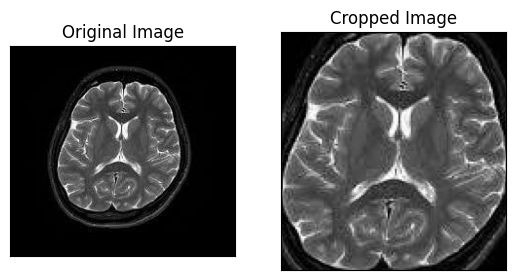

In [3]:
ex_img = cv2.imread('DatasetV1/No/Te-no_0131.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

# Function to load the Data

In [4]:
def load_data(dir_list, image_size):
    """
    Read images, resize, and normalize them.
    Arguments:
        dir_list: list of strings representing file directories for each class.
        image_size: tuple representing the desired image size (width, height).
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    X = []
    y = []
    image_width, image_height = image_size

    for class_idx, class_dir in enumerate(dir_list):
        for filename in listdir(class_dir):
            # Load the image
            image = cv2.imread(class_dir + '/' + filename)
            # Crop the brain contour
            image = crop_brain_contour(image)
            # Resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # Normalize values
            image = image / 255.
            # Convert image to numpy array and append it to X
            X.append(image)
            # Append the class index to the target array y
            y.append([class_idx])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    return X, y

Now use this function to load up our Training Dataset

In [5]:
glioma = 'DatasetV1/Yes/glioma'
meningioma = 'DatasetV1/Yes/meningioma'
pituitary = 'DatasetV1/Yes/pituitary'
no_tumor = 'DatasetV1/No'

IMG_WIDTH, IMG_HEIGHT = (224, 224)

X, y = load_data([no_tumor, glioma, meningioma, pituitary], (IMG_WIDTH, IMG_HEIGHT))
print(f'Number of examples is: {len(X)}')
print(f'X shape is: {X.shape}')
print(f'y shape is: {y.shape}')

Number of examples is: 1860
X shape is: (1860, 224, 224, 3)
y shape is: (1860, 1)


# Plot the Sample Images

In [6]:
def plot_sample_images(X, y, n_per_class=10):
    """
    Plots n_per_class sample images for each class.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
        n_per_class: Number of sample images to plot for each class
    """
    columns_n = 10
    rows_n = n_per_class // columns_n

    plt.figure(figsize=(20, 15))

    for label in [0, 1, 2, 3]:
        # Select images with the corresponding label
        images = X[y[:, 0] == label][:n_per_class]

        for i in range(n_per_class):
            plt.subplot(4, columns_n, label * columns_n + i + 1)
            plt.imshow(images[i])
            # Set title based on class label
            class_label = "No Tumor" if label == 0 else ("Glioma" if label == 1 else ("Meningioma" if label == 2 else "Pituitary"))
            plt.title(f"{class_label}")
            plt.axis('off')

    plt.suptitle("Sample Images from Each Class")
    plt.tight_layout()
    plt.show()



Plot the Training images

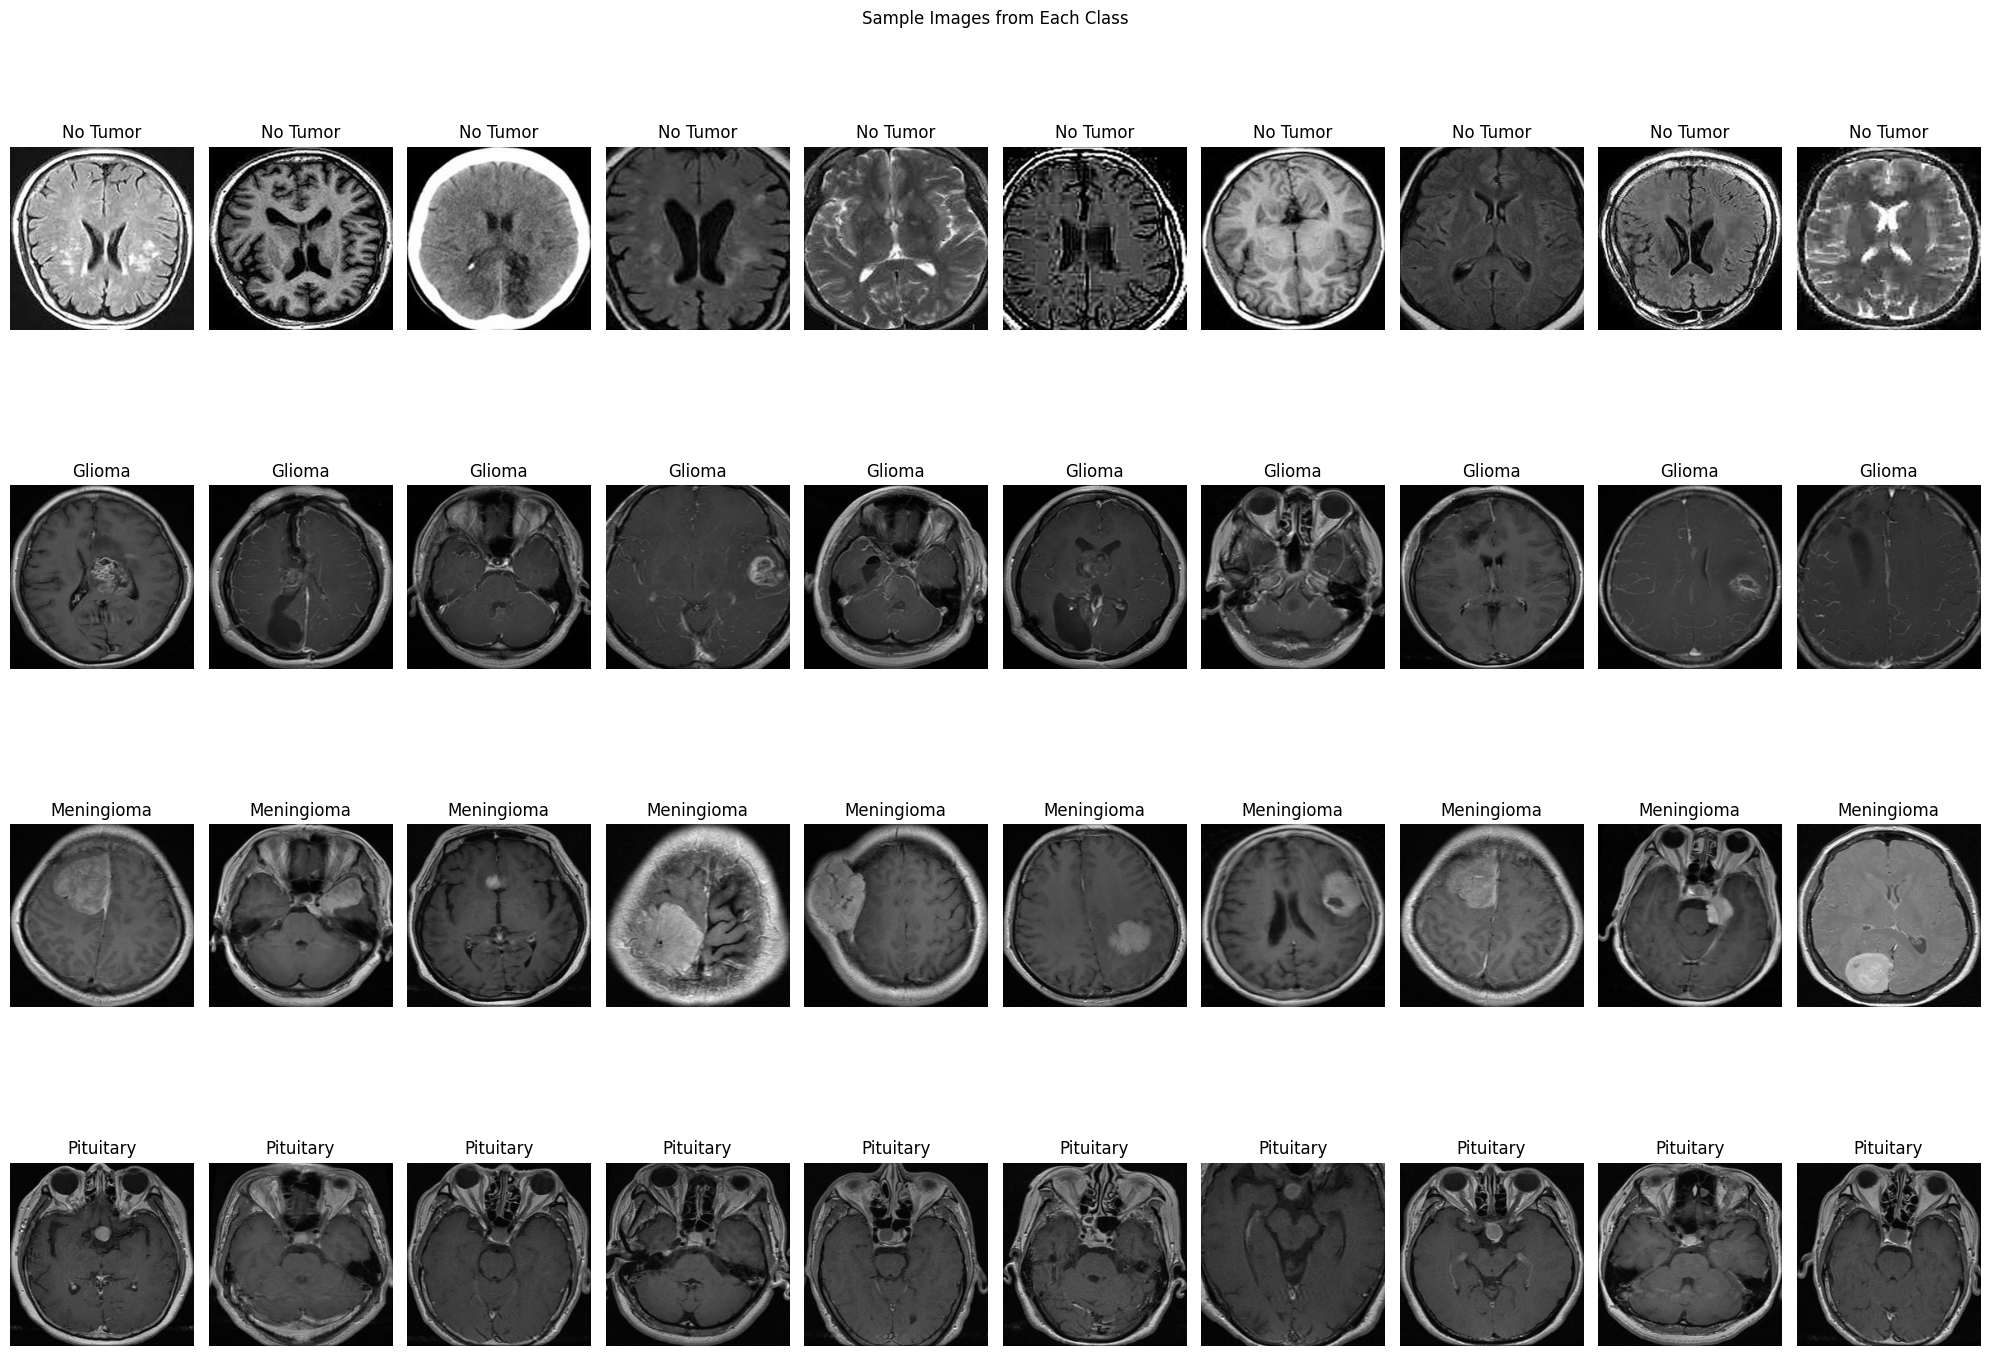

In [7]:
plot_sample_images(X, y)

# Split the Training data into Training and Validation sets

Splitting the data as following:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5)

In [9]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1302
number of development examples = 279
number of test examples = 279
X_train shape: (1302, 224, 224, 3)
Y_train shape: (1302, 1)
X_val (dev) shape: (279, 224, 224, 3)
Y_val (dev) shape: (279, 1)
X_test shape: (279, 224, 224, 3)
Y_test shape: (279, 1)


#Create and compile the Model

In [10]:
# Define the input shape
input_shape = (224, 224, 3)

# Create the base model from the pre-trained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Add new top layers
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')  # Assuming you have 4 classes
])

# Compile the model
model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [11]:
# TensorBoard
log_file_name = f'models/brain_tumor_detection_Resnet_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

# Checkpoint
# Unique file name that will include the epoch and the validation (development) accuracy
filepath = "Brain_Tumor_Resnet-{epoch:02d}-{val_accuracy:.2f}.h5"
# Save the model after every epoch
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')

Adding some helper Functions

In [16]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

# Train the Model

Start with 10 Epochs

In [18]:
start_time = time.time()

# Train the model
start_time = time.time()
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[tensorboard, checkpoint]
)
end_time = time.time()

# Print the elapsed time
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
41/41 [==============================] - ETA: 0s - loss: 0.9065 - accuracy: 0.7680 
Epoch 1: saving model to Brain_Tumor_Resnet-01-0.22.h5
41/41 [==============================] - 614s 14s/step - loss: 0.9065 - accuracy: 0.7680 - val_loss: 20352.0820 - val_accuracy: 0.2222
Epoch 2/10
41/41 [==============================] - ETA: 0s - loss: 0.5774 - accuracy: 0.8103 
Epoch 2: saving model to Brain_Tumor_Resnet-02-0.22.h5
41/41 [==============================] - 585s 14s/step - loss: 0.5774 - accuracy: 0.8103 - val_loss: 174.2581 - val_accuracy: 0.2222
Epoch 3/10
41/41 [==============================] - ETA: 0s - loss: 0.4522 - accuracy: 0.8602 
Epoch 3: saving model to Brain_Tumor_Resnet-03-0.22.h5
41/41 [==============================] - 581s 14s/step - loss: 0.4522 - accuracy: 0.8602 - val_loss: 477.5741 - val_accuracy: 0.2186
Epoch 4/10
41/41 [==============================] - ETA: 0s - loss: 0.2989 - accuracy: 0.8971 
Epoch 4: saving model to Brain_Tumor_Resnet-04-0.22.h5

Train for a few more Epochs

In [19]:
start_time = time.time()

# Train the model
start_time = time.time()
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=5,
    validation_data=(X_val, y_val),
    callbacks=[tensorboard, checkpoint]
)
end_time = time.time()

# Print the elapsed time
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}"x

Epoch 1/5
41/41 [==============================] - ETA: 0s - loss: 0.1656 - accuracy: 0.9524 
Epoch 1: saving model to Brain_Tumor_Resnet-01-0.22.h5
41/41 [==============================] - 562s 13s/step - loss: 0.1656 - accuracy: 0.9524 - val_loss: 4.5603 - val_accuracy: 0.2222
Epoch 2/5
41/41 [==============================] - ETA: 0s - loss: 0.0671 - accuracy: 0.9808 
Epoch 2: saving model to Brain_Tumor_Resnet-02-0.22.h5
41/41 [==============================] - 552s 13s/step - loss: 0.0671 - accuracy: 0.9808 - val_loss: 5.2354 - val_accuracy: 0.2222
Epoch 3/5
41/41 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9900 
Epoch 3: saving model to Brain_Tumor_Resnet-03-0.22.h5
41/41 [==============================] - 553s 14s/step - loss: 0.0333 - accuracy: 0.9900 - val_loss: 11.6003 - val_accuracy: 0.2222
Epoch 4/5
41/41 [==============================] - ETA: 0s - loss: 0.0637 - accuracy: 0.9846 
Epoch 4: saving model to Brain_Tumor_Resnet-04-0.22.h5
41/41 [===

In [20]:
start_time = time.time()

# Train the model
start_time = time.time()
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=5,
    validation_data=(X_val, y_val),
    callbacks=[tensorboard, checkpoint]
)
end_time = time.time()

# Print the elapsed time
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
41/41 [==============================] - ETA: 0s - loss: 0.1311 - accuracy: 0.9555 
Epoch 1: saving model to Brain_Tumor_Resnet-01-0.25.h5
41/41 [==============================] - 563s 13s/step - loss: 0.1311 - accuracy: 0.9555 - val_loss: 3.7494 - val_accuracy: 0.2545
Epoch 2/5
41/41 [==============================] - ETA: 0s - loss: 0.0750 - accuracy: 0.9793 
Epoch 2: saving model to Brain_Tumor_Resnet-02-0.22.h5
41/41 [==============================] - 552s 13s/step - loss: 0.0750 - accuracy: 0.9793 - val_loss: 6.6128 - val_accuracy: 0.2222
Epoch 3/5
41/41 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.9877 
Epoch 3: saving model to Brain_Tumor_Resnet-03-0.23.h5
41/41 [==============================] - 552s 13s/step - loss: 0.0424 - accuracy: 0.9877 - val_loss: 10.2509 - val_accuracy: 0.2330
Epoch 4/5
41/41 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9946 
Epoch 4: saving model to Brain_Tumor_Resnet-04-0.23.h5
41/41 [===

In [21]:
start_time = time.time()

# Train the model
start_time = time.time()
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[tensorboard, checkpoint]
)
end_time = time.time()

# Print the elapsed time
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
41/41 [==============================] - ETA: 0s - loss: 0.0553 - accuracy: 0.9816 
Epoch 1: saving model to Brain_Tumor_Resnet-01-0.73.h5
41/41 [==============================] - 609s 14s/step - loss: 0.0553 - accuracy: 0.9816 - val_loss: 1.0879 - val_accuracy: 0.7276
Epoch 2/10
41/41 [==============================] - ETA: 0s - loss: 0.1021 - accuracy: 0.9708 
Epoch 2: saving model to Brain_Tumor_Resnet-02-0.40.h5
41/41 [==============================] - 590s 14s/step - loss: 0.1021 - accuracy: 0.9708 - val_loss: 1.9179 - val_accuracy: 0.3978
Epoch 3/10
41/41 [==============================] - ETA: 0s - loss: 0.0704 - accuracy: 0.9816 
Epoch 3: saving model to Brain_Tumor_Resnet-03-0.47.h5
41/41 [==============================] - 554s 14s/step - loss: 0.0704 - accuracy: 0.9816 - val_loss: 4.7144 - val_accuracy: 0.4731
Epoch 4/10
41/41 [==============================] - ETA: 0s - loss: 0.0609 - accuracy: 0.9823 
Epoch 4: saving model to Brain_Tumor_Resnet-04-0.23.h5
41/41 [

#Plot Loss and Accuracy

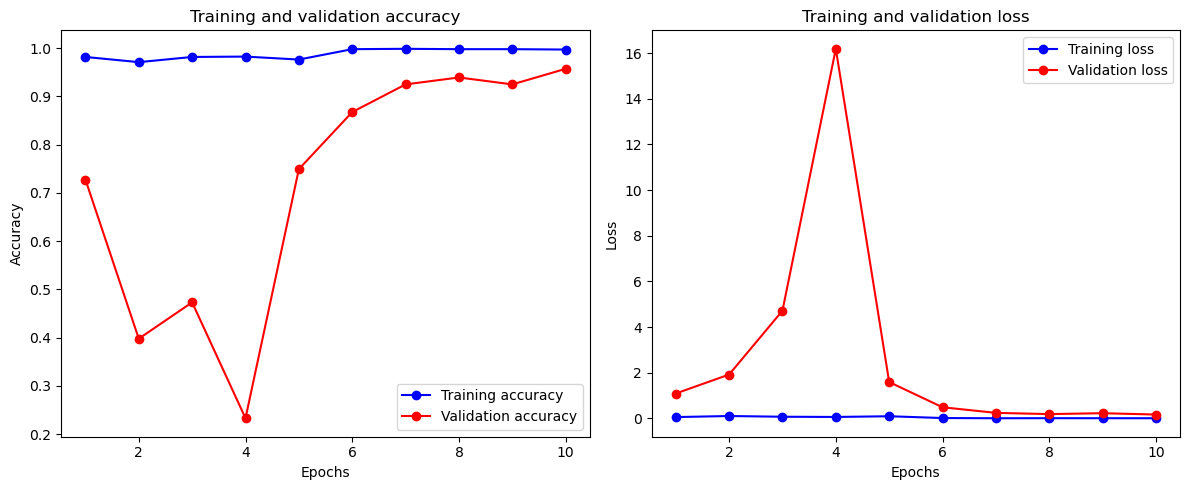

In [23]:
def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy.

    Arguments:
    history: The history object returned by the model.fit() method.
    """
    # Extract data from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Results

Let's experiment with the best model (the one with the best validation accuracy):

In [25]:
best_model = load_model(filepath='Brain_Tumor_Resnet-10-0.96.h5')

In [26]:
loss, accuracy = best_model.evaluate(x=X_test, y=y_test)

9/9 [==============================] - 24s 2s/step - loss: 0.3213 - accuracy: 0.9462


### Accuracy of the best model on the testing data

In [27]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {accuracy}")

Test Loss = 0.32128357887268066
Test Accuracy = 0.9462365508079529
